In [ ]:
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 4.2 MB/s eta 0:00:00


In [ ]:
import torch
from matplotlib import pyplot as plt

# B1

## Generating data

In [ ]:
def g(x):
    """
    g(x) = - (sin(6*pi*x))^2 + 6*x^2 - 5*x^4 + 1.5
    """
    return -(torch.sin(6.0 * torch.pi * x))**2 + 6.0*x**2 - 5.0*x**4 + 1.5

def generate_data(device = 'cuda'):

    # Defining the grid x_i = (i-1)/(l-1) for i=1..l with l=30
    l = 30
    x = torch.linspace(0.0, 1.0, l, device = device)  # same as (i-1)/(l-1)

    # Computing y_i = g(x_i) + epsilon_i, where epsilon_i ~ N(0, 0.01)
    noise_std = torch.sqrt(torch.tensor(0.01, device = device))  # standard deviation = 0.1
    y_true = g(x)
    epsilon = torch.normal(0.0, noise_std, size = (l,), device = device)
    y = y_true + epsilon

    # Randomly splitting into 20 training points and 10 test points
    idx = torch.randperm(l, device = device)
    train_idx = idx[:20]
    test_idx  = idx[20:]

    x_train = x[train_idx]
    y_train = y[train_idx]
    x_test  = x[test_idx]
    y_test  = y[test_idx]

    return x_train, y_train, x_test, y_test


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

x_train, y_train, x_test, y_test = generate_data(device = device)

y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean)/y_std
y_test = (y_test - y_mean)/y_std

Using device: cuda


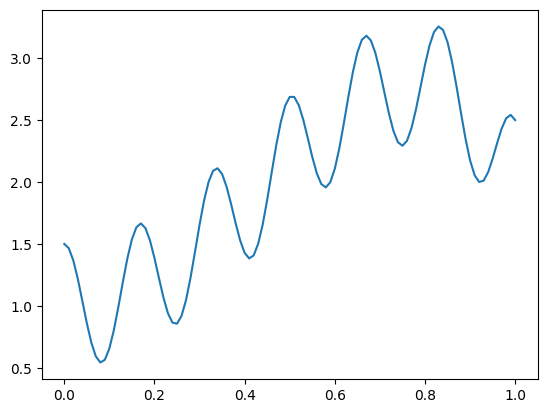

In [ ]:
plt.plot(torch.linspace(0,1,101), g(torch.linspace(0,1,101)))
plt.show()

## Defining kernel

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Defining kernels as Torch tensors, for Pyro

def rbf_kernel(x, xp, alpha, length):
    """
    RBF/Gaussian kernel (PyTorch, GPU-compatible).
    x, xp: 1D torch tensors on the same device.
    """
    x_col = x.unsqueeze(-1)     # shape (n, 1)
    xp_row = xp.unsqueeze(0)    # shape (1, m)
    sqdist = (x_col - xp_row)**2
    return alpha**2 * torch.exp(-0.5 * sqdist / (length**2))


def periodic_kernel(x, xp, alpha, length, period=1.0):
    """
    Periodic kernel (PyTorch, GPU-compatible).
    """
    x_col = x.unsqueeze(-1)
    xp_row = xp.unsqueeze(0)
    diff = x_col - xp_row
    sin_sq = torch.sin(torch.pi * diff / period)**2
    return alpha**2 * torch.exp(-2.0 * sin_sq / (length**2))


def summed_kernel(x, xp, alpha_rbf, length_rbf, alpha_per, length_per, period):
    """
    Sum of RBF and Periodic kernels (PyTorch, GPU-compatible).
    """
    K_rbf = rbf_kernel(x, xp, alpha_rbf, length_rbf)
    K_per = periodic_kernel(x, xp, alpha_per, length_per, period)
    return K_rbf + K_per


Using device: cuda


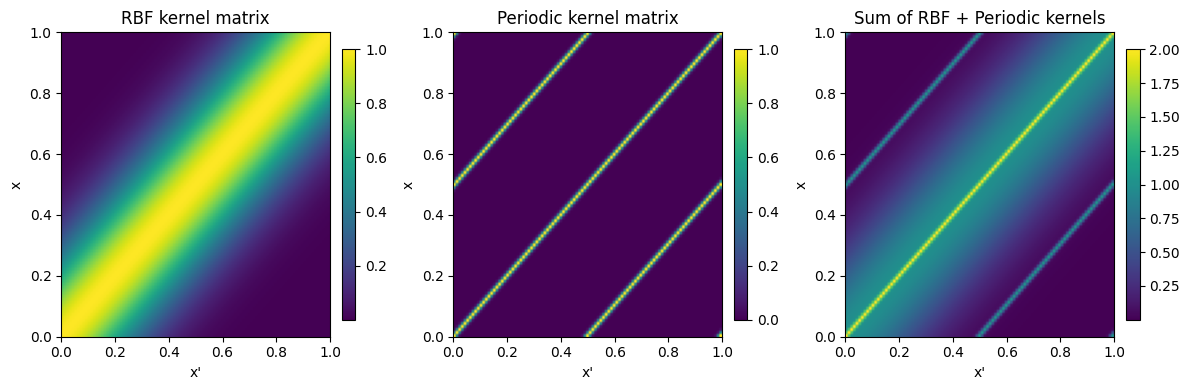

In [ ]:
""" Visualising the kernel matrices"""

# Creating a grid of x-values in [0, 1]
n_grid = 101
x_grid = torch.linspace(0., 1., n_grid, device = device)

# Example hyperparameters for plotting kernels
alpha_rbf = 1.0
length_rbf = 0.2

alpha_per = 1.0
length_per = 0.1
period = 0.5

params = torch.tensor([1.0, 0.5, 1.0, 0.2, 1/6], device='cuda')

# RBF kernel matrix
K_rbf = rbf_kernel(x_grid, x_grid, alpha_rbf, length_rbf)

# Periodic kernel matrix
K_per = periodic_kernel(x_grid, x_grid, alpha_per, length_per, period)

# Summed kernel matrix
K_sum = summed_kernel(x_grid, x_grid, alpha_rbf, length_rbf, alpha_per, length_per, period)

# Moving kernel matrices to CPU for visualization
K_rbf = K_rbf.cpu().numpy()
K_per = K_per.cpu().numpy()
K_sum = K_sum.cpu().numpy()

# Plot each kernel matrix side by side
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# RBF
im0 = axs[0].imshow(K_rbf, origin='lower', extent=[0,1,0,1], aspect='auto', cmap='viridis')
axs[0].set_title("RBF kernel matrix")
axs[0].set_xlabel("x'")
axs[0].set_ylabel("x")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# Periodic
im1 = axs[1].imshow(K_per, origin='lower', extent=[0,1,0,1], aspect='auto', cmap='viridis')
axs[1].set_title("Periodic kernel matrix")
axs[1].set_xlabel("x'")
axs[1].set_ylabel("x")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# Summed
im2 = axs[2].imshow(K_sum, origin='lower', extent=[0,1,0,1], aspect='auto', cmap='viridis')
axs[2].set_title("Sum of RBF + Periodic kernels")
axs[2].set_xlabel("x'")
axs[2].set_ylabel("x")
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Functions for -log_likelihood and optimizing params (based on lecture)

In [ ]:
# priors for params:
# all follow a LogNorm(mu, sigma), given by:
mus = torch.tensor([torch.log(torch.tensor(0.5)), torch.log(torch.tensor(1.0)), torch.log(torch.tensor(0.5)), torch.log(torch.tensor(1.0)), torch.log(torch.tensor(1.0))], device='cuda')
sigmas = torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5], device='cuda')
params = torch.tensor([0.5, 1.0, 0.5, 1.0, 1.0], device='cuda')

def log_prior(params, mus, sigmas):
    """
    theta: array of shape (5,) -> [alpha_rbf, length_rbf, alpha_per, length_per, period]
    mus:   array of shape (5,) -> log-space means for each param
    sigmas:array of shape (5,) -> log-space std dev for each param

    Returns the sum of log-likelihoods under independent lognormal priors.
    """
    total_logp = torch.tensor(0.0, device = params.device)
    for p, mu, sigma in zip(params, mus, sigmas):
        # If the parameter is non-positive, the lognormal pdf is 0 => logpdf = -inf
        if p <= 0:
            return torch.tensor(float('-inf'), device = params.device)

        # log-normal from PyTorch
        lognorm = torch.distributions.LogNormal(loc = mu, scale = sigma)
        lp = lognorm.log_prob(p)
        total_logp += lp

    return total_logp

def negLogLikelihood(params, X = x_train, y = y_train, verbose = False):

    alpha_rbf, length_rbf, alpha_per, length_per, period = params

    noise_y = 0.01
    sigma_y_I = noise_y * torch.eye(y.shape[0], device=X.device)

    K = summed_kernel(X, X, alpha_rbf, length_rbf, alpha_per, length_per, period)

    K_inv = torch.linalg.inv(K + sigma_y_I)
    observed_fit = y.T @ K_inv @ y

    # Computing model complexity
    model_complexity = torch.logdet(K + sigma_y_I)

    # Computing the log-prior
    log_pr = log_prior(params, mus, sigmas)

    if verbose:
      print(f"data fit={np.round(observed_fit,2)}")
      print(f"model complexity={np.round(model_complexity,2)}")
      print(f"log-prior={np.round(log_pr, 2)}")

    # Combine terms to compute negative log-posterior
    ll = -0.5 * observed_fit - 0.5 * model_complexity - log_pr

    # small HACK to avoid -inf of problematic regions
    if torch.isinf(ll) or torch.isnan(ll):
        return torch.tensor(float('inf'), device = X.device) # NOTE: we optimize by minimization, hence large positive value should be discarded by opt routine
    return -ll # NEGATIVE loglikelihood

def optimize_params(ranges, x_train, y_train, Ngrid):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    x_train = torch.tensor(x_train, dtype = torch.float32, device = device)
    y_train = torch.tensor(y_train, dtype = torch.float32, device = device)
    param_grid = torch.stack([torch.linspace(r[0], r[1], Ngrid, device = device) for r in ranges], dim = 1).reshape(-1, len(ranges))

    opt_params = None
    nll_min = float('inf')

    # Checking all parameter combinations in a loop
    for params in param_grid:
      nll = negLogLikelihood(params, x_train, y_train)
      if nll < nll_min:
        nll_min = nll
        opt_params = params

    opt_params = opt_params.cpu().numpy() # Moving results to CPU in the end
    print(f"optimized NLL={nll}")
    return opt_params

In [ ]:
# Function for conditioning on data (based on lecture)
def conditional(X, x_star, y, noise_var, kernel):
    # See eq. 66 in the lecture notes. Note that there is a small error: Instead of (S) it should be K(S)
    sigma_I = noise_var * torch.eye(y.shape[0], device = X.device)

    # Cholesky decomposition for numerical stability
    L = torch.linalg.cholesky(kernel(X, X) + sigma_I)

    # Solving K @ alpha = y
    alpha = torch.cholesky_solve(y.unsqueeze(-1), L)

    mu_star = kernel(X, x_star).T @ alpha

    # Computing posterior covariance
    v = torch.cholesky_solve(kernel(X, x_star), L)
    sigma_star = kernel(x_star, x_star) - kernel(X, x_star).T @ v

    return mu_star.squeeze(-1), sigma_star # return mean and covariance matrix

In [ ]:
"""MAP"""

ranges = [(0.1, 2.0), (0.1, 2.0), (0.1, 2.0), (0.1, 2.0), (0.1, 2.0)]
Ngrid = 10

optimal_parameters = optimize_params(ranges, x_train, y_train, Ngrid)
print("optimal params:", optimal_parameters)

optimized NLL=32.773231506347656
optimal params: [0.5222222 0.5222222 0.5222222 0.5222222 0.5222222]


<ipython-input-7-e8bc23341f55>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype = torch.float32, device = device)
<ipython-input-7-e8bc23341f55>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype = torch.float32, device = device)


In [ ]:
optimal_parameters

array([0.3422222, 0.3422222, 0.3422222, 0.3422222, 0.3422222],
      dtype=float32)

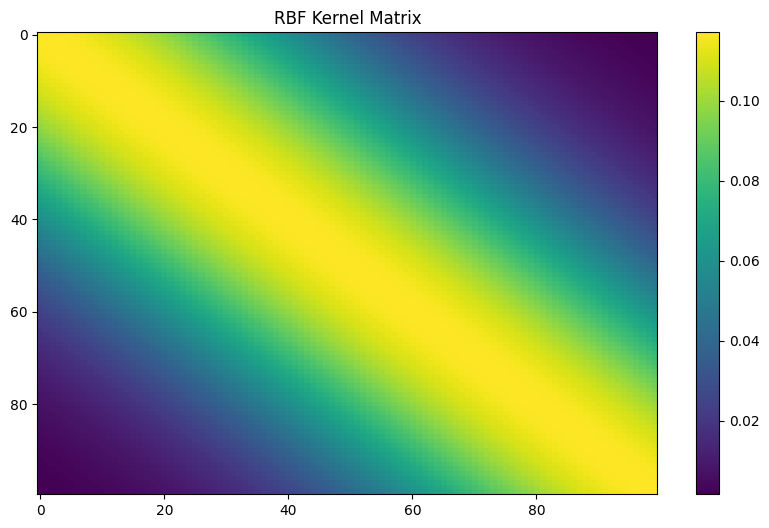

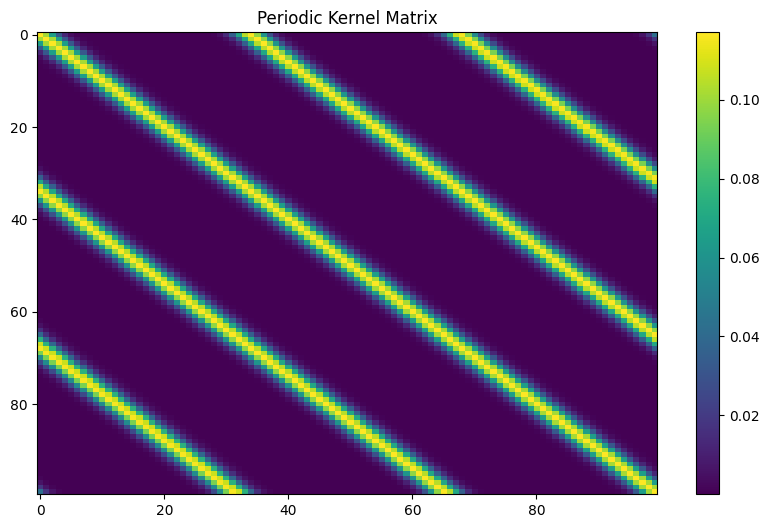

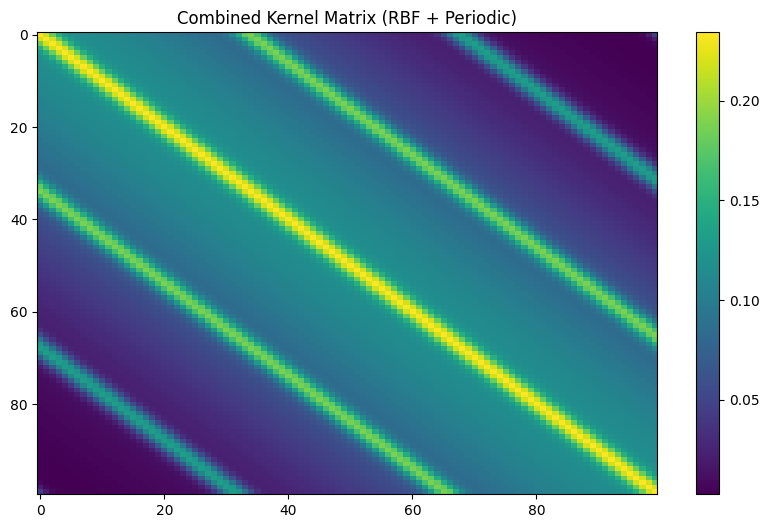

In [ ]:
""" Visualising kernels contribution"""

# Optimal hyperparameters
alpha_rbf, length_rbf = optimal_parameters[0], optimal_parameters[1]
alpha_per, length_per, period = optimal_parameters[2], optimal_parameters[3], optimal_parameters[4]

# Creating a grid of input points
x_grid = torch.linspace(0, 1, 100, device=device)  # 100 evenly spaced points

# Computing individual kernel matrices
K_rbf = rbf_kernel(x_grid, x_grid, alpha_rbf, length_rbf)
K_per = periodic_kernel(x_grid, x_grid, alpha_per, length_per, period)
K_combined = K_rbf + K_per

# Moving kernel matrices to CPU and convert to NumPy for visualization
K_rbf_np = K_rbf.cpu().numpy()
K_per_np = K_per.cpu().numpy()
K_combined_np = (K_rbf + K_per).cpu().numpy()

# Visualize RBF Kernel Contribution
plt.figure(figsize=(10, 6))
plt.imshow(K_rbf_np, aspect='auto', cmap='viridis')
plt.title("RBF Kernel Matrix")
plt.colorbar()
plt.show()

# Visualize Periodic Kernel Contribution
plt.figure(figsize=(10, 6))
plt.imshow(K_per_np, aspect='auto', cmap='viridis')
plt.title("Periodic Kernel Matrix")
plt.colorbar()
plt.show()

# Visualize Combined Kernel Contribution
plt.figure(figsize=(10, 6))
plt.imshow(K_combined_np, aspect='auto', cmap='viridis')
plt.title("Combined Kernel Matrix (RBF + Periodic)")
plt.colorbar()
plt.show()

## NUTS

In [ ]:
import arviz as az

In [ ]:
#!pip install pyro-ppl

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Pyro model definition
def gp_model(x_train, y_train, noise_std=0.1):

    # Ensure x_train, y_train are Tensors on the correct device
    x_train = torch.as_tensor(x_train, dtype=torch.float32, device=device)
    y_train = torch.as_tensor(y_train, dtype=torch.float32, device=device)

    # Sample hyperparameters as torch Tensors
    alpha_rbf  = pyro.sample("alpha_rbf",  dist.LogNormal(0.5, 0.5))
    length_rbf = pyro.sample("length_rbf", dist.LogNormal(1, 0.5))
    alpha_per  = pyro.sample("alpha_per",  dist.LogNormal(0.5, 0.5))
    length_per = pyro.sample("length_per", dist.LogNormal(1, 0.5))
    period     = pyro.sample("period_rbf", dist.LogNormal(1, 0.5))

    # Build covariance K on GPU using previously defined kernels
    K = summed_kernel(x_train, x_train, alpha_rbf, length_rbf, alpha_per, length_per, period=period)
    # Add noise to diagonal
    K_noise = K + noise_std**2 * torch.eye(len(x_train), device=device)

    # Zero mean
    mean = torch.zeros_like(x_train)

    # Observe data
    pyro.sample("obs", dist.MultivariateNormal(mean, covariance_matrix=K_noise), obs=y_train)

def run_mcmc(x_train, y_train, noise_std=0.1, num_samples=1000, warmup_steps=500):
    """
    Run MCMC using NUTS on the Gaussian Process model.
    """
    pyro.clear_param_store()
    nuts_kernel = NUTS(gp_model, step_size=0.01, adapt_step_size=True)
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=1)
    mcmc.run(x_train, y_train, noise_std=noise_std)
    return mcmc

# Run MCMC
mcmc = run_mcmc(x_train, y_train, noise_std=0.1, num_samples=500,warmup_steps=200)

# Retrieve samples
samples = mcmc.get_samples()
for name, val in samples.items():
    print(name, val.shape, val.mean(dim=0))

Using device: cuda


Sample: 100%|██████████| 700/700 [02:04,  5.64it/s, step size=2.28e-01, acc. prob=0.852]

alpha_per torch.Size([500]) tensor(1.3708, device='cuda:0')
alpha_rbf torch.Size([500]) tensor(1.6063, device='cuda:0')
length_per torch.Size([500]) tensor(0.3343, device='cuda:0')
length_rbf torch.Size([500]) tensor(2.8458, device='cuda:0')
period_rbf torch.Size([500]) tensor(1.2190, device='cuda:0')


In [ ]:
print(mcmc.diagnostics()["divergences"])

{'chain 0': []}


/usr/local/lib/python3.11/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([[<Axes: title={'center': 'alpha_per'}>,
        <Axes: title={'center': 'alpha_per'}>],
       [<Axes: title={'center': 'alpha_rbf'}>,
        <Axes: title={'center': 'alpha_rbf'}>],
       [<Axes: title={'center': 'length_per'}>,
        <Axes: title={'center': 'length_per'}>],
       [<Axes: title={'center': 'length_rbf'}>,
        <Axes: title={'center': 'length_rbf'}>],
       [<Axes: title={'center': 'period_rbf'}>,
        <Axes: title={'center': 'period_rbf'}>]], dtype=object)

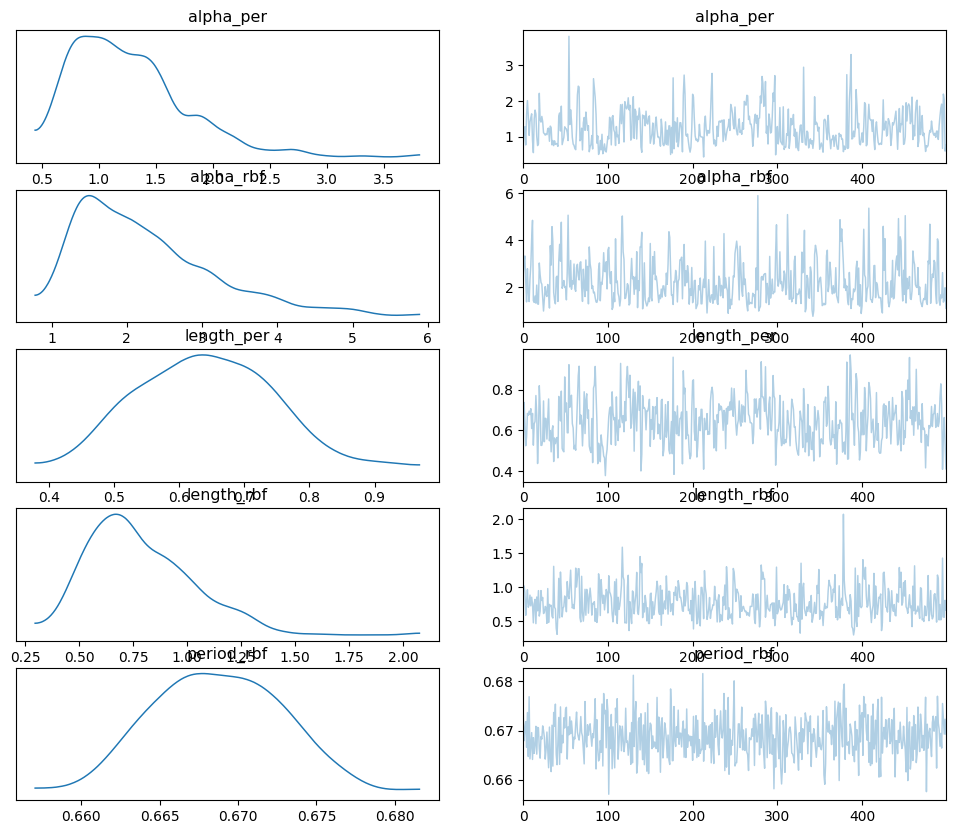

In [ ]:
import arviz as az
idata = az.from_pyro(mcmc)
az.plot_trace(idata)


In [ ]:
def gp_post_pred(x_train, y_train, x_grid, alpha_rbf, length_rbf, alpha_per, length_per, period, noise_std=0.1):
    """
    Compute the GP posterior predictive mean and covariance at x_test
    given training data (x_train, y_train) and known hyperparams.
    Returns (mean_test, cov_test).
    """
    x_train = torch.as_tensor(x_train, dtype=torch.float32, device="cpu")
    y_train = torch.as_tensor(y_train, dtype=torch.float32, device="cpu")
    x_grid = torch.as_tensor(x_grid, dtype=torch.float32, device="cpu")

    K_train = summed_kernel(x_train, x_train, alpha_rbf, length_rbf, alpha_per, length_per, period)
    K_train_noise = (K_train + noise_std**2 * torch.eye(len(x_train))).numpy()

    K_cross = summed_kernel(x_train, x_grid, alpha_rbf, length_rbf, alpha_per, length_per, period).numpy()  # (n_train x n_test)
    K_test_test = summed_kernel(x_grid, x_grid, alpha_rbf, length_rbf, alpha_per, length_per, period).numpy()  # (n_test x n_test)

    # Use a stable approach with e.g. np.linalg.cholesky
    L = np.linalg.cholesky(K_train_noise)
    # Solve L * L^T * alpha = y_train
    alpha = np.linalg.solve(L, y_train)
    alpha = np.linalg.solve(L.T, alpha)  # => alpha = inv(K_train_noise) * y_train

    mean_test = K_cross.T @ alpha  # shape (n_test,)


    v = np.linalg.solve(L, K_cross)
    v = np.linalg.solve(L.T, v)  # => v = inv(K_train_noise) * K_cross
    cov_test = K_test_test - K_cross.T @ v

    return mean_test, cov_test

In [ ]:
def plot_gp_functions(x_train, y_train, x_grid, mean_test, cov_test, title, x_test = None, y_test = None, n_samples=3):
    """
    Function to plot GP functions with training data and predictions.
    """
    x_train = x_train.cpu().numpy() if isinstance(x_train, torch.Tensor) else x_train
    y_train = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
    x_grid = x_grid.cpu().numpy() if isinstance(x_grid, torch.Tensor) else x_grid
    mean_test = mean_test.cpu().numpy() if isinstance(mean_test, torch.Tensor) else mean_test
    cov_test = cov_test.cpu().numpy() if isinstance(cov_test, torch.Tensor) else cov_test

    if x_test is not None:
        x_test = x_test.cpu().numpy() if isinstance(x_test, torch.Tensor) else x_test
    if y_test is not None:
        y_test = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

    # Plotting training data
    plt.figure(figsize=(15, 5))
    plt.scatter(x_train, y_train, color='k', alpha=0.8, label="Train data")

    # Plotting predictive mean
    plt.plot(x_grid, mean_test, color='blue', label="Predictive mean")

    # Plotting confidence intervals
    std_test = np.sqrt(np.diag(cov_test))
    plt.fill_between(x_grid, mean_test - 1.96 * std_test, mean_test + 1.96 * std_test,
                     color='blue', alpha=0.2, label="95% Confidence Interval")

    # Plotting posterior samples
    samples = np.random.multivariate_normal(mean_test, cov_test + 1e-6 * np.eye(len(cov_test)), size=n_samples)
    for i, sample in enumerate(samples):
        plt.plot(x_grid, sample, alpha=0.6, label=f"Sample {i + 1}")


    plt.plot(torch.linspace(0,1,1001), g(torch.linspace(0,1,1001)), color = 'red', label = 'True Function')

    # Plotting test datapoints
    if x_test is not None and y_test is not None:
      plt.scatter(x_test, y_test, color = 'red', marker = 'x', label = 'Test data')
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show()

In [ ]:
samples = mcmc.get_samples()
for name, val in samples.items():
    print(name, val.shape, val.mean(dim=0))

alpha_per torch.Size([500]) tensor(1.2586, device='cuda:0')
alpha_rbf torch.Size([500]) tensor(2.2460, device='cuda:0')
length_per torch.Size([500]) tensor(0.6442, device='cuda:0')
length_rbf torch.Size([500]) tensor(0.7798, device='cuda:0')
period_rbf torch.Size([500]) tensor(0.6687, device='cuda:0')


In [ ]:
list(samples.values())[0].mean()

tensor(1.2586, device='cuda:0')

In [ ]:

K_combined
K_combined_np

array([[0.23423208, 0.21822992, 0.18244372, ..., 0.00794653, 0.01978678,
        0.04459011],
       [0.21822992, 0.23423208, 0.21822992, ..., 0.00376802, 0.00794653,
        0.01978678],
       [0.18244372, 0.21822992, 0.23423208, ..., 0.00269115, 0.00376802,
        0.00794653],
       ...,
       [0.00794653, 0.00376802, 0.00269115, ..., 0.23423208, 0.21822989,
        0.18244365],
       [0.01978678, 0.00794653, 0.00376802, ..., 0.21822989, 0.23423208,
        0.21822989],
       [0.04459011, 0.01978678, 0.00794653, ..., 0.18244365, 0.21822989,
        0.23423208]], dtype=float32)

In [ ]:
from scipy.stats import multivariate_normal
def compute_posterior_likelihood(x_train, y_train, x_test, y_test, samples, noise_std=0.1):
    """
    Compute the approximate posterior likelihood using MCMC samples.
    """
    posterior_likelihoods = []

    for i in range(500):  # Use the first 500 samples
        alpha_rbf = samples["alpha_rbf"][i].cpu().item()
        length_rbf = samples["length_rbf"][i].cpu().item()
        alpha_per = samples["alpha_per"][i].cpu().item()
        length_per = samples["length_per"][i].cpu().item()
        period = samples["period_rbf"][i].cpu().item()

        # Compute posterior mean and covariance for test set
        mean_test, cov_test = gp_post_pred(
            x_train, y_train, x_test,
            alpha_rbf, length_rbf, alpha_per, length_per, period, noise_std
        )

        # Compute log-likelihood of test set
        try:
            likelihood = multivariate_normal.logpdf(
                y_test.cpu().numpy(),
                mean=mean_test,
                cov=cov_test + noise_std**2 * np.eye(len(cov_test))
            )
            posterior_likelihoods.append(likelihood)
        except np.linalg.LinAlgError:
            print(f"Numerical issue in sample {i}, skipping.")
            continue

    # Compute the mean posterior log-likelihood
    approx_posterior_likelihood = np.mean(posterior_likelihoods)
    return approx_posterior_likelihood

# Compute posterior likelihood for the test set
approx_posterior_likelihood = compute_posterior_likelihood(
    x_train, y_train, x_test, y_test, samples, noise_std=0.1
)
print(f"Approximate Posterior Test Set Log-Likelihood: {approx_posterior_likelihood}")

Approximate Posterior Test Set Log-Likelihood: 3.935928734217711


optimal parameters, MCMC:  2.245965003967285 0.6687396168708801 1.2585787773132324 0.644179105758667 0.6687396168708801
optimal parameters, MAP:  0.5222222 0.5222222 0.5222222 0.5222222 0.5222222


<ipython-input-79-4cdd2e00911c>:30: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean_test, cov_test + 1e-6 * np.eye(len(cov_test)), size=n_samples)


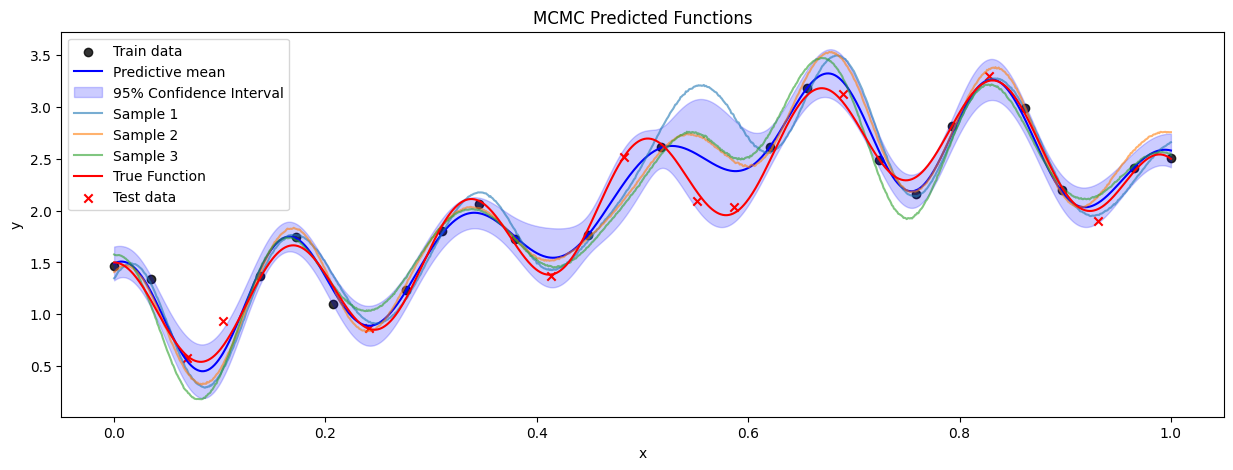

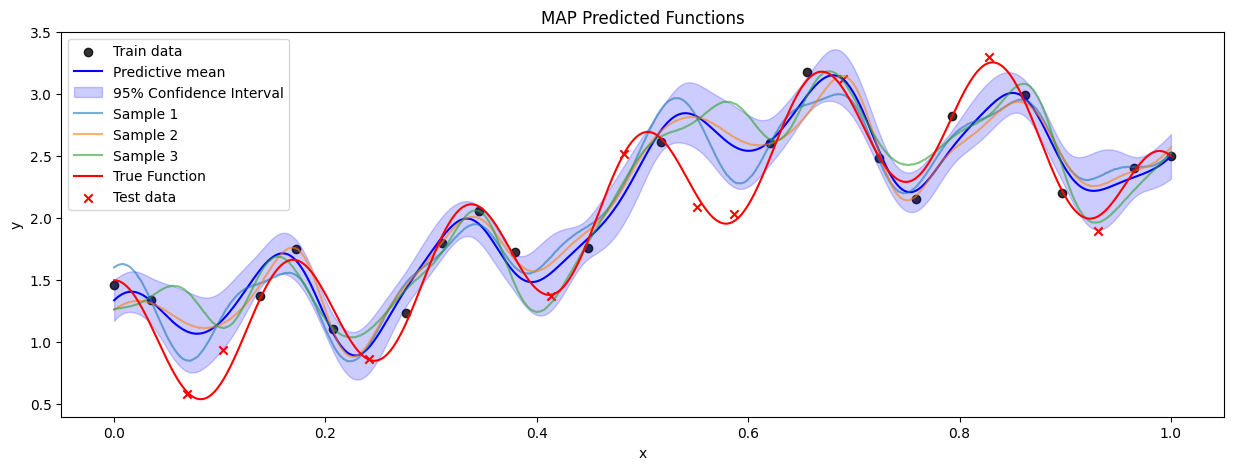

In [ ]:
""" Comparing on the plots"""

x_grid = torch.linspace(0, 1, 1001).to(device)
alpha_rbf, length_rbf = list(samples.values())[1].mean(dim=0).item(), list(samples.values())[4].mean(dim=0).item()
alpha_per, length_per, period = list(samples.values())[0].mean(dim=0).item(), list(samples.values())[2].mean(dim=0).item(), list(samples.values())[4].mean(dim=0).item()
noise_std = 0.1

map_alpha_rbf, map_length_rbf = optimal_parameters[0], optimal_parameters[1]
map_alpha_per, map_length_per, map_period = optimal_parameters[2], optimal_parameters[3], optimal_parameters[4]

# Compute predictions
mean_test, cov_test = gp_post_pred(x_train, y_train, x_grid, alpha_rbf, length_rbf, alpha_per, length_per, period, noise_std)
print("optimal parameters, MCMC: ", alpha_rbf, length_rbf, alpha_per, length_per, period)
print("optimal parameters, MAP: ", map_alpha_rbf, map_length_rbf, map_alpha_per, map_length_per, map_period)


# Plotting results for MCMC
plot_gp_functions(x_train, y_train, x_grid, mean_test, cov_test, title = "MCMC Predicted Functions", x_test = x_test, y_test = y_test, n_samples=3)

# MAP predictions
map_mean_test, map_cov_test = gp_post_pred(x_train, y_train, x_grid, map_alpha_rbf, map_length_rbf, map_alpha_per, map_length_per, map_period, noise_std)

# Plotting results for MAP
plot_gp_functions(x_train, y_train, x_grid, map_mean_test, map_cov_test, title = "MAP Predicted Functions", x_test = x_test, y_test = y_test, n_samples=3)

In [ ]:
# Compute MAP predictions specifically for x_test
map_mean_test, map_cov_test = gp_post_pred(
    x_train, y_train, x_test,
    map_alpha_rbf, map_length_rbf,
    map_alpha_per, map_length_per, map_period,
    noise_std
)
# Compute posterior log-likelihood for test set
from scipy.stats import multivariate_normal

map_log_likelihood = multivariate_normal.logpdf(
    y_test.cpu().numpy(),
    mean=map_mean_test,
    cov=map_cov_test + noise_std**2 * np.eye(len(map_cov_test))
)

print(f"MAP Test Set Log-Likelihood: {map_log_likelihood}")

MAP Test Set Log-Likelihood: 5.239885922780817


#

In [ ]:
print(f"MAP Test Set Log-Likelihood: {map_log_likelihood}")
print(f"MCMC Approximate Posterior Test Set Log-Likelihood: {approx_posterior_likelihood}")

if approx_posterior_likelihood > map_log_likelihood:
    print("MCMC captures the posterior uncertainty better than MAP.")
else:
    print("MAP performs better than MCMC.")

MAP Test Set Log-Likelihood: 5.239885922780817
MCMC Approximate Posterior Test Set Log-Likelihood: 1.280645176199865
MAP performs better or is comparable to MCMC.


In [ ]:
"""5"""

map_likelihoods = []
posterior_likelihoods = []

for _ in range(20):
    x_train, y_train, x_test, y_test = generate_data(device)
    optimal_parameters = optimize_params(ranges, x_train, y_train, Ngrid)
    map_alpha_rbf, map_length_rbf = optimal_parameters[:2]
    map_alpha_per, map_length_per, map_period = optimal_parameters[2:]

    # Compute MAP log-likelihood
    map_mean_test, map_cov_test = gp_post_pred(x_train, y_train, x_test, map_alpha_rbf, map_length_rbf, map_alpha_per, map_length_per, map_period, noise_std)
    map_log_likelihood = multivariate_normal.logpdf(
        y_test.cpu().numpy(),
        mean=map_mean_test,
        cov=map_cov_test + noise_std**2 * np.eye(len(map_cov_test))
    )
    map_likelihoods.append(map_log_likelihood)

    # Compute posterior likelihood
    mcmc = run_mcmc(x_train, y_train, noise_std=0.1, num_samples=500,warmup_steps=200)
    samples = mcmc.get_samples()
    likelihoods = []
    for i in range(500):
        params = {key: val[i].item() for key, val in samples.items()}
        mean_test, cov_test = gp_post_pred(
            x_train, y_train, x_test,
            params["alpha_rbf"], params["length_rbf"],
            params["alpha_per"], params["length_per"], params["period_rbf"],
            noise_std
        )
        likelihood = multivariate_normal.logpdf(
            y_test.cpu().numpy(),
            mean=mean_test,
            cov=cov_test + noise_std**2 * np.eye(len(cov_test))
        )
        likelihoods.append(likelihood)
    posterior_likelihoods.append(np.mean(likelihoods))
    print(f"MAP Test Likelihood: {map_log_likelihood}, MCMC Test Likelihood: {np.mean(likelihoods)}")

print(f"MAP Test Likelihoods: Mean = {np.mean(map_likelihoods)}, Std = {np.std(map_likelihoods)}")
print(f"MCMC Test Likelihoods: Mean = {np.mean(posterior_likelihoods)}, Std = {np.std(posterior_likelihoods)}")


<ipython-input-7-e8bc23341f55>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype = torch.float32, device = device)
<ipython-input-7-e8bc23341f55>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype = torch.float32, device = device)


optimized NLL=80.65484619140625


Sample: 100%|██████████| 700/700 [02:00,  5.81it/s, step size=4.00e-01, acc. prob=0.933]


MAP Test Likelihood: 3.6720530184878903, MCMC Test Likelihood: 2.5305879645420863
optimized NLL=71.85520935058594


Sample: 100%|██████████| 700/700 [03:03,  3.82it/s, step size=4.38e-01, acc. prob=0.889]


MAP Test Likelihood: 4.883238851584714, MCMC Test Likelihood: 7.650133451679612
optimized NLL=75.58350372314453


Sample: 100%|██████████| 700/700 [01:24,  8.25it/s, step size=3.55e-01, acc. prob=0.951]


MAP Test Likelihood: 4.820383975681791, MCMC Test Likelihood: 4.759790358394846
optimized NLL=64.44998168945312


Sample: 100%|██████████| 700/700 [00:56, 12.44it/s, step size=4.52e-01, acc. prob=0.925]


MAP Test Likelihood: -1.9908847161397727, MCMC Test Likelihood: -83.21054050189024
optimized NLL=92.66429138183594


Sample: 100%|██████████| 700/700 [05:21,  2.18it/s, step size=2.84e-01, acc. prob=0.861]


MAP Test Likelihood: -7.807653548307918, MCMC Test Likelihood: -17.564286597966376
optimized NLL=53.62828826904297


Sample: 100%|██████████| 700/700 [02:26,  4.78it/s, step size=1.63e-01, acc. prob=0.898]


MAP Test Likelihood: 2.3484310924728504, MCMC Test Likelihood: 2.898717932132515
optimized NLL=76.92753601074219


Sample: 100%|██████████| 700/700 [01:05, 10.69it/s, step size=4.75e-01, acc. prob=0.920]


MAP Test Likelihood: -0.28255940723784967, MCMC Test Likelihood: 1.6461359966866578
optimized NLL=45.666725158691406


Sample: 100%|██████████| 700/700 [02:43,  4.28it/s, step size=3.29e-01, acc. prob=0.942]


MAP Test Likelihood: -2.5103310488249146, MCMC Test Likelihood: 5.293004660849207
optimized NLL=63.30957794189453


Sample: 100%|██████████| 700/700 [05:02,  2.31it/s, step size=2.18e-01, acc. prob=0.920]


MAP Test Likelihood: -4.46444557267875, MCMC Test Likelihood: -27.496611505887014
optimized NLL=63.24836730957031


Sample: 100%|██████████| 700/700 [02:22,  4.93it/s, step size=2.29e-01, acc. prob=0.841]


MAP Test Likelihood: -5.7674092404636355, MCMC Test Likelihood: 1.7834801510913445
optimized NLL=87.00892639160156


Sample: 100%|██████████| 700/700 [01:06, 10.55it/s, step size=5.16e-01, acc. prob=0.928]


MAP Test Likelihood: 4.6577335135517455, MCMC Test Likelihood: 4.479869756117206
optimized NLL=31.79361343383789


Sample: 100%|██████████| 700/700 [07:14,  1.61it/s, step size=1.65e-01, acc. prob=0.950]


MAP Test Likelihood: -1.414332437873016, MCMC Test Likelihood: -2.618968889868107
optimized NLL=73.28741455078125


Sample: 100%|██████████| 700/700 [01:54,  6.10it/s, step size=2.16e-01, acc. prob=0.863]


MAP Test Likelihood: -6.698043960631114, MCMC Test Likelihood: 2.4139690419269755
optimized NLL=76.3044204711914


Sample: 100%|██████████| 700/700 [01:56,  6.03it/s, step size=2.34e-01, acc. prob=0.871]


MAP Test Likelihood: -1.945072531423122, MCMC Test Likelihood: 1.709584325695501
optimized NLL=61.62335968017578


Sample: 100%|██████████| 700/700 [01:52,  6.24it/s, step size=2.63e-01, acc. prob=0.894]


MAP Test Likelihood: 1.326525947476652, MCMC Test Likelihood: 3.2938964333069096
optimized NLL=29.831275939941406


Sample: 100%|██████████| 700/700 [01:49,  6.41it/s, step size=4.77e-01, acc. prob=0.927]


MAP Test Likelihood: -2.201195943843093, MCMC Test Likelihood: -0.7036910797454262
optimized NLL=66.70069885253906


Sample: 100%|██████████| 700/700 [02:09,  5.39it/s, step size=3.99e-01, acc. prob=0.929]


MAP Test Likelihood: -2.7250536793398616, MCMC Test Likelihood: 0.4604396176063934
optimized NLL=100.43617248535156


Sample: 100%|██████████| 700/700 [02:38,  4.42it/s, step size=1.59e-01, acc. prob=0.863]


MAP Test Likelihood: -4.896569398875856, MCMC Test Likelihood: 0.8820040208674965
optimized NLL=82.31201934814453


Sample: 100%|██████████| 700/700 [02:29,  4.67it/s, step size=4.17e-01, acc. prob=0.932]


MAP Test Likelihood: -14.86922210159614, MCMC Test Likelihood: 1.466042382422289
optimized NLL=31.711750030517578


Sample: 100%|██████████| 700/700 [03:09,  3.69it/s, step size=4.08e-01, acc. prob=0.938]


MAP Test Likelihood: 2.3907795187006933, MCMC Test Likelihood: 3.935928734217711
MAP Test Likelihoods: Mean = -1.673681383463935, Std = 4.856514972940398
MCMC Test Likelihoods: Mean = -4.31952568739102, Std = 19.7622654420715


(array([1., 0., 0., 1., 2., 2., 6., 1., 3., 4.]),
 array([-14.8692221 , -12.89397601, -10.91872991,  -8.94348382,
         -6.96823772,  -4.99299163,  -3.01774553,  -1.04249943,
          0.93274666,   2.90799276,   4.88323885]),
 <BarContainer object of 10 artists>)

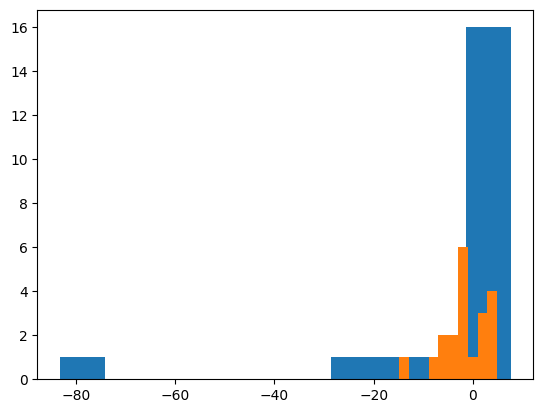

In [ ]:
plt.hist(posterior_likelihoods)
plt.hist(map_likelihoods)